# Basic imports

In [193]:
from functools import partial
import pandas, csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression as LR
from sklearn.metrics import roc_curve, auc, hamming_loss, zero_one_loss, \
    jaccard_similarity_score, precision_score, recall_score, roc_auc_score, make_scorer
from sklearn.cross_validation import StratifiedKFold as SKF, cross_val_score, KFold
from sklearn import cross_validation
from scipy.special import expit
from sklearn.multiclass import OneVsRestClassifier

# Real data

Results in X, Y

In [2]:
dataPath = "../data/"

# reading CSV file
reader = csv.reader(open(dataPath + 'features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open(dataPath + 'all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))
badValue = 999

In [3]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

# Normalization
df = pandas.DataFrame(X)
df_norm = (df - df.mean()) / (df.max() - df.min())
X = np.copy(df_norm.as_matrix())

Protein names equality check: True


In [237]:
print receptor_names

['NR-AhR' 'NR-AR-LBD' 'NR-AR' 'SR-MMP' 'NR-ER' 'SR-HSE' 'SR-p53'
 'NR-PPAR-gamma' 'SR-ARE' 'NR-Aromatase' 'SR-ATAD5' 'NR-ER-LBD']


# Model data

Results in Xm, Ym

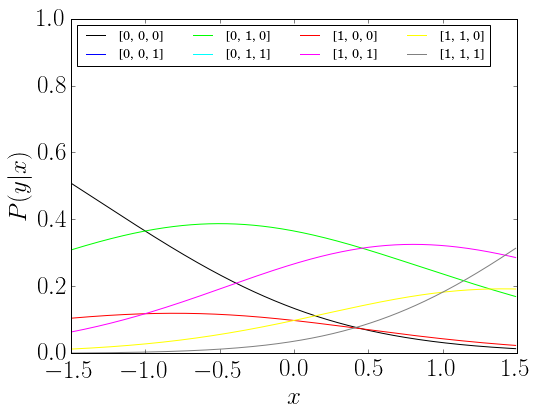

In [121]:
import ModelData
reload(ModelData)            

m = 500

# Model data
Xm, Ym = ModelData.get(m)

# Enable to show and save a chart
ModelData.plotDistribution()

# Number of classes
l = ModelData.l

## Using data

In [240]:
# Selectinv NR-s
i = 0
for x in receptor_names:
    if x[0:2] == 'NR':
        print x,i
    i += 1

NR-AhR 0
NR-AR-LBD 1
NR-AR 2
NR-ER 4
NR-PPAR-gamma 7
NR-Aromatase 9
NR-ER-LBD 11


In [243]:
# Real
l = 3
rs = [0,1,9]
print receptor_names[rs]
Yc = Y[:, rs]
ind = np.all(Yc != badValue, axis = 1)
Xc = np.copy(X[ind])
Yc = np.copy(Yc[ind])

['NR-AhR' 'NR-AR-LBD' 'NR-Aromatase']


## Base estimator

Will use it for both BR and PCC

In [282]:
#,
estimator = LR(class_weight = 'balanced', fit_intercept = True, solver='liblinear', n_jobs=2, penalty='l2', )

## Cross validation strategy

In [283]:
cv = cross_validation.ShuffleSplit(Xc.shape[0], n_iter=5, test_size=.1, random_state=0)
#cv = KFold(Xc.shape[0], n_folds = , random_state = 179)

## Array of metrics

In [284]:
import MLCCV
reload(MLCCV)
import MLCLoss
reload(MLCLoss)

# Metrics for each column
column_metrics = {"H": MLCLoss.HammingLossN, "P": precision_score, "R": recall_score, "AUC": roc_auc_score}

# Metrics for whole matrices
metrics = {"S": MLCLoss.subsetLossN, "H": MLCLoss.HammingLossN}

# Make a matrix metric from column metric
for m in column_metrics:
    for i in range(1, l + 1):
        metrics[m + " " + str(i)] = partial(MLCCV.metric_ith_column, f = column_metrics[m], i = i - 1)

## Results

In [285]:
# result: classifiers x metrics x folds
result = {}

## Training BR

In [286]:
BR = OneVsRestClassifier(estimator, n_jobs = 3)

result["BR"] = MLCCV.cross_val_score_multiple_metrics(estimator = BR, metrics = metrics,
                                cv = cv, X = Xc, Y = Yc)

## Array of losses for PCC

In [287]:
losses = {"H": MLCLoss.HammingLoss, "S": MLCLoss.subsetLoss}
#losses['M1'] = partial(MLCLoss.middleLoss, t = [0, 2, 5, 10])
losses['M2'] = partial(MLCLoss.middleLoss, t = [0, 1, 6, 10])
#losses['M3'] = partial(MLCLoss.middleLoss, t = [0, 0, 2, 10])

# Array of middle losses
#x1 = 0
#step = 0.5
#while x1 <= 10:
#    x2 = x1
#    while x2 <= 10:
#        losses["M" + str((0, x1, x2, 10))] = partial(MLCLoss.middleLoss, t = [0, x1, x2, 10])
#        x2 += step
#    x1 += step

## Training PCC

In [288]:
import PCC
reload(PCC)
for loss in losses:
    print "PCC LOSS " + loss
    classifier = PCC.PCC(estimator = estimator, loss = losses[loss])
    
    result["PCC_" + loss] = MLCCV.cross_val_score_multiple_metrics(estimator = classifier, metrics = metrics,
                                cv = cv, X = Xc, Y = Yc)

PCC LOSS H
i=0 coef=[[-0.18623328  0.25948697 -0.01428498 -0.15550828  0.27421419  1.51098892
  -0.54554329  0.17250409  1.49962141  0.38686989  0.09849246 -2.03720939
   0.03848439  0.5731283  -0.05156138  0.10511218  1.32554308  1.29876773
   1.67264281 -1.61078471 -1.05843633 -2.11744236  0.40191778 -0.40731497
  -1.37631946  1.21583015  0.40133773  1.1184278  -1.01135623 -0.3420754
   0.86301001  0.43602668  1.41829045  0.05477763  0.03586231  2.26945179
   0.17089654  0.92000649 -0.77393267  2.33754932  0.1005496   1.90398635
   0.92890211  0.06320762 -0.61113193  0.35799373 -0.12274063  0.68560309
  -0.46284582  1.19397334 -0.79188005 -0.79188005 -0.25669491  0.77303774
  -0.96528007 -0.12569644  0.97680864  0.23441568  0.70407416 -0.96714312
  -1.05758852 -0.76476882  0.40842693 -0.44240312  3.53365661 -1.56892556
  -0.01926739 -0.32307245  0.74834814  0.15893016  1.327989   -0.24511322
  -1.58598545  1.70788016 -0.30101934  0.22513297 -0.58076043  0.5372293
   0.32724339 -0.573

## Finding best loss function for a metric

In [289]:
for m in metrics:
    MLCLoss.bestLoss(result, m)

max P 3 PCC_S 0.824481074481
max P 2 PCC_M2 0.908333333333
max P 1 PCC_S 0.816936592819
min H BR 0.150887021475
max R 3 BR 0.100668174717
max R 1 PCC_S 0.179503533832
min S PCC_S 0.297478991597
max R 2 PCC_M2 0.235626566416
min H 3 BR 0.196078431373
min H 2 PCC_M2 0.0408963585434
min H 1 PCC_S 0.206162464986
max AUC 1 PCC_S 0.583870314605
max AUC 2 PCC_M2 0.617227630415
max AUC 3 BR 0.54642428441


## Printing results

In [290]:
res_mean_std = {}
for a in result:
    res_mean_std[a] = {}
    for b in result[a]:
        m = np.mean(result[a][b])
        s = np.std(result[a][b])
        r = "%0.2g +- %0.1g" % (m, s)
        #print a,b,r
        res_mean_std[a][b] = r
df = pandas.DataFrame(res_mean_std)
#df.to_csv("ModelData_SearchingForLossFunction.csv", sep='\t', encoding='utf-8')
df.to_csv("RealData_Result1.csv", sep='\t', encoding='utf-8')

In [291]:
df

,BR,PCC_H,PCC_M2,PCC_S
AUC 1,0.58 +- 0.03,0.58 +- 0.03,0.57 +- 0.02,0.58 +- 0.02
AUC 2,0.61 +- 0.06,0.61 +- 0.06,0.62 +- 0.06,0.61 +- 0.05
AUC 3,0.55 +- 0.01,0.54 +- 0.01,0.53 +- 0.01,0.54 +- 0.01
H,0.15 +- 0.01,0.17 +- 0.01,0.19 +- 0.02,0.17 +- 0.02
H 1,0.21 +- 0.03,0.21 +- 0.03,0.24 +- 0.02,0.21 +- 0.03
H 2,0.045 +- 0.01,0.041 +- 0.007,0.041 +- 0.008,0.041 +- 0.006
H 3,0.2 +- 0.02,0.25 +- 0.01,0.29 +- 0.03,0.25 +- 0.03
P 1,0.79 +- 0.1,0.79 +- 0.1,0.79 +- 0.1,0.82 +- 0.1
P 2,0.91 +- 0.1,0.88 +- 0.1,0.91 +- 0.1,0.88 +- 0.1
P 3,0.76 +- 0.07,0.82 +- 0.09,0.78 +- 0.09,0.82 +- 0.08


In [292]:
print df.to_latex()

\begin{tabular}{lllll}
\toprule
{} &             BR &           PCC\_H &          PCC\_M2 &           PCC\_S \\
\midrule
AUC 1 &   0.58 +- 0.03 &    0.58 +- 0.03 &    0.57 +- 0.02 &    0.58 +- 0.02 \\
AUC 2 &   0.61 +- 0.06 &    0.61 +- 0.06 &    0.62 +- 0.06 &    0.61 +- 0.05 \\
AUC 3 &   0.55 +- 0.01 &    0.54 +- 0.01 &    0.53 +- 0.01 &    0.54 +- 0.01 \\
H     &   0.15 +- 0.01 &    0.17 +- 0.01 &    0.19 +- 0.02 &    0.17 +- 0.02 \\
H 1   &   0.21 +- 0.03 &    0.21 +- 0.03 &    0.24 +- 0.02 &    0.21 +- 0.03 \\
H 2   &  0.045 +- 0.01 &  0.041 +- 0.007 &  0.041 +- 0.008 &  0.041 +- 0.006 \\
H 3   &    0.2 +- 0.02 &    0.25 +- 0.01 &    0.29 +- 0.03 &    0.25 +- 0.03 \\
P 1   &    0.79 +- 0.1 &     0.79 +- 0.1 &     0.79 +- 0.1 &     0.82 +- 0.1 \\
P 2   &    0.91 +- 0.1 &     0.88 +- 0.1 &     0.91 +- 0.1 &     0.88 +- 0.1 \\
P 3   &   0.76 +- 0.07 &    0.82 +- 0.09 &    0.78 +- 0.09 &    0.82 +- 0.08 \\
R 1   &   0.17 +- 0.06 &    0.17 +- 0.06 &    0.15 +- 0.04 &    0.18 +- 0.05 \\

## Analyzing classifier coefficients

In [101]:
print np.mean(np.abs(classifier.C[0].coef_))
print np.max(np.abs(classifier.C[0].coef_))
print np.min(np.abs(classifier.C[0].coef_))
np.where(np.abs(classifier.C[0].coef_) > 2)

0.673325810251
3.38338529893
3.12649288104e-05


(array([0, 0, 0, 0, 0, 0, 0, 0]),
 array([ 11,  19,  39,  64,  88, 142, 152, 159]))

In [102]:
print np.where(np.abs(classifier.C[0].coef_) > 2)
print np.where(np.abs(classifier.C[1].coef_) > 2)
print np.where(np.abs(classifier.C[2].coef_) > 2)

(array([0, 0, 0, 0, 0, 0, 0, 0]), array([ 11,  19,  39,  64,  88, 142, 152, 159]))
(array([0, 0, 0, 0, 0, 0, 0, 0, 0]), array([ 23,  27,  31,  41,  65,  75, 115, 128, 146]))
(array([0, 0, 0]), array([ 72,  80, 166]))


## Analyzing real dataframe

In [128]:
yy=pandas.DataFrame(Yc)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c9c85dcd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5c9c701d10>]], dtype=object)

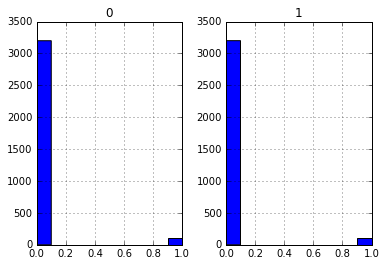

In [129]:
yy.hist()

In [66]:

yyy=pandas.DataFrame(YY)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5c9de1a290>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f5c9ceba9d0>]], dtype=object)

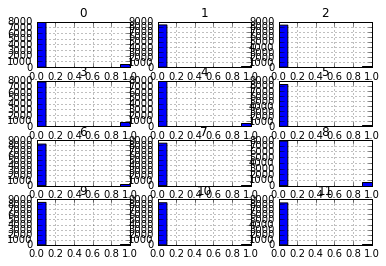

In [67]:
yyy.hist()

In [90]:
np.sum(np.all(YY[:,:] == 0,axis=1))

6155

In [74]:
YY.shape

(8513, 12)

In [78]:
#from MLCCommon import getB
for v in getB(12)
    

[[0], [1]]

In [98]:
v = getB(12)[6]
v

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0]

In [103]:
np.all(Y == v, axis = 0)

array([False, False, False, False, False, False, False, False, False,
       False, False, False], dtype=bool)

In [112]:
Y[0]
DF = pandas.DataFrame

In [118]:
for i in range(13):
    print i,np.sum(np.sum(Y[:,:]==999,axis=1) == i)

0 1397
1 834
2 1366
3 735
4 529
5 376
6 229
7 172
8 134
9 207
10 1684
11 850
12 0


In [144]:
np.sum(Y[:,:]==999,axis=0)

array([3413, 3213, 2904, 3925, 3746, 3309, 3174, 3393, 3791, 4544, 2951,
       3107])

In [219]:
res=[]

i = 0
while i < 12:
    j = i + 1
    while j < 12:
        e = np.sum(np.all(Y[:, [i,j]]==1,axis=1))
        f = np.sum(np.all(Y[:, [i]]==1,axis=1))
        g = np.sum(np.all(Y[:, [j]]==1,axis=1))
        res.append([i,j,k,receptor_names[i],receptor_names[j],e,f,g])
        j += 1
    i += 1

#for i in range(12):
#    res[i] = {}
##    for j in range(12):
 #       a = np.sum(np.all(Y[:, [i,j]]!=999,axis=1))
 #       b = np.sum(np.all(Y[:, [i,j]]==1,axis=1))
 #       res[i][j] = [a,b,receptor_names[i],receptor_names[j]]
    

In [220]:
DF(res)

,0,1,2,3,4,5,6,7
0,0,1,12,NR-AhR,NR-AR-LBD,11,597,171
1,0,2,12,NR-AhR,NR-AR,23,597,211
2,0,3,12,NR-AhR,SR-MMP,179,597,718
3,0,4,12,NR-AhR,NR-ER,132,597,535
4,0,5,12,NR-AhR,SR-HSE,35,597,243
5,0,6,12,NR-AhR,SR-p53,70,597,310
6,0,7,12,NR-AhR,NR-PPAR-gamma,18,597,133
7,0,8,12,NR-AhR,SR-ARE,133,597,693
8,0,9,12,NR-AhR,NR-Aromatase,49,597,134
9,0,10,12,NR-AhR,SR-ATAD5,92,597,202


In [221]:
DF(res).sort(5)

/home/etoestja/Documents/j/venv/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,0,1,2,3,4,5,6,7
23,2,5,12,NR-AR,SR-HSE,2,211,243
57,7,9,12,NR-PPAR-gamma,NR-Aromatase,3,133,134
25,2,7,12,NR-AR,NR-PPAR-gamma,4,211,133
18,1,9,12,NR-AR-LBD,NR-Aromatase,5,171,134
63,9,10,12,NR-Aromatase,SR-ATAD5,6,134,202
27,2,9,12,NR-AR,NR-Aromatase,6,211,134
48,5,9,12,SR-HSE,NR-Aromatase,7,243,134
64,9,11,12,NR-Aromatase,NR-ER-LBD,10,134,238
24,2,6,12,NR-AR,SR-p53,10,211,310
0,0,1,12,NR-AhR,NR-AR-LBD,11,597,171


In [182]:
print receptor_names[11]

NR-ER-LBD
